# 1. Initalize Script

If you're running this script on Google Colab<br>
Mount your Google drive: 
1. Click on the folder icon on the left
2. Click Mount Drive
3. The root directory would be /content/
```
# your Google Drive folder would be at:
/content/drive/My Drive/
```

Change working directory:<br>
1. Run this command:
```
%cd /content/drive/My Drive/<your folder>
```

In [1]:
%cd /content/drive/My Drive/Data Science/Stock Prediction

/content/drive/My Drive/Data Science/Stock Prediction


# 2. Load

In [ ]:
!pip3 install yahoo_fin requests_html

In [19]:
# from src.helper import datetime_string_to_datetime
# start_date = datetime_string_to_datetime('2020-01-01', '%Y-%m-%d')
from datetime import date, datetime, timedelta
start_date = datetime.today() - timedelta(days=365*5)
from yahoo_fin import stock_info as si
df = si.get_data("AAPL", start_date=start_date)
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,open,high,low,close,adjclose,volume,ticker
2015-06-22,127.489998,128.059998,127.080002,127.610001,117.606491,34039300,AAPL
2015-06-23,127.480003,127.610001,126.879997,127.029999,117.071945,30268900,AAPL
2015-06-24,127.209999,129.800003,127.120003,128.110001,118.067299,55280900,AAPL
2015-06-25,128.860001,129.199997,127.500000,127.500000,117.505127,31938100,AAPL
2015-06-26,127.669998,127.989998,126.510002,126.750000,116.813896,44066800,AAPL
...,...,...,...,...,...,...,...
2020-06-12,344.720001,347.799988,334.220001,338.799988,338.799988,50001500,AAPL
2020-06-15,333.250000,345.679993,332.579987,342.989990,342.989990,34702200,AAPL
2020-06-16,351.459991,353.200012,344.720001,352.079987,352.079987,41357200,AAPL
2020-06-17,355.149994,355.399994,351.089996,351.589996,351.589996,28532000,AAPL


In [3]:
import plotly.graph_objs as go

go.Figure(
    data=go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close']
    ),
    layout={
        'title':'AAPL',
        'xaxis':go.layout.XAxis(title=go.layout.xaxis.Title(text="Time")),
        'yaxis':go.layout.YAxis(title=go.layout.yaxis.Title(text="Price $ - US Dollars")),
        'height':900
    }
).show()

# 3. Prepare date set

In [101]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
def prepare_data(df, cols, window_params=(30, 1)):
    for col in cols:
        assert col in df.columns.tolist()

    df['future'] = df['adjclose'].shift(-1)

    cols_scaler = {}
    for col in cols:
        scaler = MinMaxScaler()
        df[col] = scaler.fit_transform(np.expand_dims(df[col].values, axis=1))
        cols_scaler[col] = scaler
    
    column_index = {
        col_name: idx for idx, col_name in enumerate(df.columns.tolist())
    }
    cols_index = [column_index.get(col) for col in cols]
    last_sequence = np.array(df.iloc[-1, cols_index])

    df.dropna(inplace=True)

    s_w, step = window_params
    idx = s_w

    features, target = [], []
    while idx < len(df):
        features.append(
            df.iloc[idx-s_w:idx, cols_index]
            .T
            .values
        )
        target.append(df.iloc[idx, column_index['future']])
        idx+=step

    last_sequence = np.array(
        list(df.iloc[idx-s_w:idx, cols_index].values) + np.array(last_sequence),
        dtype=np.float
    )

    features, target = np.array(features), np.array(target)
    # features = features.reshape(
    #     (features.shape[0], features.shape[2], features.shape[1])
    # )

    print(features.shape, target.shape)

    return features, target, last_sequence, cols_scaler

features, target, last_sequence, cols_scaler = prepare_data(df, cols)

(1222, 6, 30) (1222,)


# 4. Prepare Model

In [102]:
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error, mean_absolute_error
from tensorflow.keras.metrics import categorical_accuracy, mae
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam

def create_model(
    input_length, n_classes,
    units=256, cell=LSTM, n_layers=2, dropout=0.3,
    loss=mean_absolute_error, metrics=[mae], optimizer=Nadam
):
    model = Sequential()
    
    for i in range(n_layers):
        if i == 0:
            # first layer
            model.add(Bidirectional(cell(
                units, 
                return_sequences=True, 
                input_shape=(None, input_length)
            )))
        elif i == n_layers - 1:
            # last layer
            model.add(Bidirectional(cell(
                units, return_sequences=False
            )))
        else:
            # hidden layers
            model.add(Bidirectional(cell(
                units, return_sequences=True
            )))
        # add dropout after each layer
        model.add(Dropout(dropout))
    
    model.add(Dense(n_classes, activation="linear"))
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

from matplotlib import pyplot as plt

def plot_model_train_history(hsitory):
    plt.figure(1) # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'val Loss'], loc='upper left')
    plt.show()

    plt.figure(2) # accuracy
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model Metrics')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['MAE', 'val MAE'], loc='upper left')
    plt.show()

In [103]:
### model parameters
CELL = GRU; LAYERS=2
# neurons
UNITS = 64; DROPOUT = 0.4

### training parameters
LOSS = mean_squared_error
OPTIMIZER = Nadam

BATCH_SIZE = 256
EPOCHS = 20

import os; import time
# create these folders if they does not exist
if not os.path.isdir("/models"): os.mkdir("/models")
if not os.path.isdir("/logs"): os.mkdir("/logs")

# date now
datetime_now = time.strftime("%Y-%m-%d, %H_%M")

# model name to save
model_name = f"{datetime_now}"
model_name+= f"-cell-{CELL.__name__}-layer-{LAYERS}-units-{UNITS}"
model_name+= f"-dropout-{DROPOUT}-loss-{LOSS.__name__}-optimizer-{OPTIMIZER.__name__}"
model_name+= f"-batch-{BATCH_SIZE}-epochs-{EPOCHS}"

OPTIMIZER = OPTIMIZER(learning_rate=0.0001)
model = create_model(
    input_length=features.shape[2], n_classes=1,
    units=UNITS, cell=CELL, n_layers=LAYERS, dropout=DROPOUT, 
    loss=LOSS, optimizer=OPTIMIZER
)

# some tensorflow callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
checkpointer = ModelCheckpoint(os.path.join("/models", model_name), save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("/logs", model_name))

##################################################
1
##################################################
Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 31865.3125 - mean_absolute_error: 167.4422
Epoch 00001: val_loss improved from inf to 29279.50586, saving model to /models/2020-06-19, 07_17-cell-GRU-layer-2-units-64-dropout-0.4-loss-mean_squared_error-optimizer-Nadam-batch-256-epochs-20
INFO:tensorflow:Assets written to: /models/2020-06-19, 07_17-cell-GRU-layer-2-units-64-dropout-0.4-loss-mean_squared_error-optimizer-Nadam-batch-256-epochs-20/assets
4/4 [==============================] - 10s 3s/step - loss: 31865.3125 - mean_absolute_error: 167.4422 - val_loss: 29279.5059 - val_mean_absolute_error: 161.1068
Epoch 2/20
3/4 [=====================>........] - ETA: 0s - loss: 32356.7422 - mean_absolute_error: 168.5880
Epoch 00002: val_loss improved from 29279.50586 to 29242.34766, saving model to /models/2020-06-19, 07_17-cell-GRU-layer-2-units-64-dropout-0.4-loss-mean_s

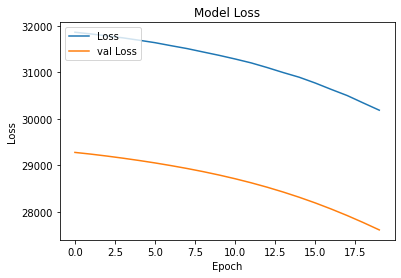

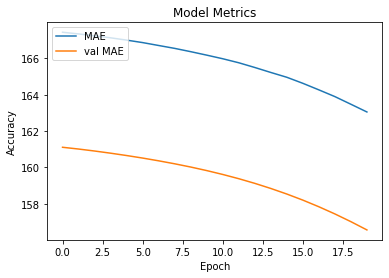

##################################################
2
##################################################
Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 29783.9922 - mean_absolute_error: 161.8823
Epoch 00001: val_loss did not improve from 27611.48438
4/4 [==============================] - 0s 60ms/step - loss: 29783.9922 - mean_absolute_error: 161.8823 - val_loss: 28395.2539 - val_mean_absolute_error: 158.9086
Epoch 2/20
3/4 [=====================>........] - ETA: 0s - loss: 29910.3438 - mean_absolute_error: 162.1360
Epoch 00002: val_loss did not improve from 27611.48438
4/4 [==============================] - 0s 37ms/step - loss: 29607.0469 - mean_absolute_error: 161.3787 - val_loss: 28219.9863 - val_mean_absolute_error: 158.3980
Epoch 3/20
3/4 [=====================>........] - ETA: 0s - loss: 29256.1270 - mean_absolute_error: 160.4157
Epoch 00003: val_loss did not improve from 27611.48438
4/4 [==============================] - 0s 36ms/step - loss: 29438.9863 - mean_ab

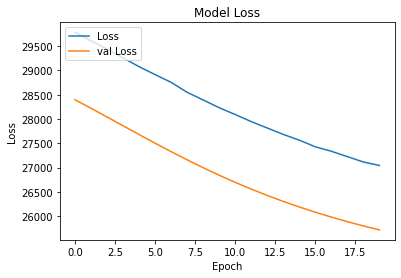

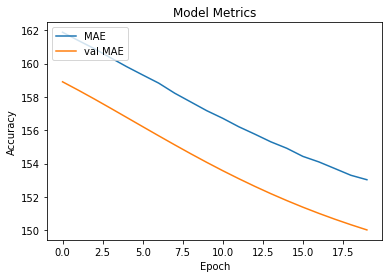

##################################################
3
##################################################
Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 26732.3730 - mean_absolute_error: 152.2748
Epoch 00001: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 45ms/step - loss: 26732.3730 - mean_absolute_error: 152.2748 - val_loss: 26655.8145 - val_mean_absolute_error: 151.7583
Epoch 2/20
3/4 [=====================>........] - ETA: 0s - loss: 26740.0625 - mean_absolute_error: 152.1871
Epoch 00002: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 36ms/step - loss: 26643.9199 - mean_absolute_error: 151.9565 - val_loss: 26584.5898 - val_mean_absolute_error: 151.4860
Epoch 3/20
3/4 [=====================>........] - ETA: 0s - loss: 26710.9297 - mean_absolute_error: 152.2031
Epoch 00003: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 37ms/step - loss: 26567.1250 - mean_ab

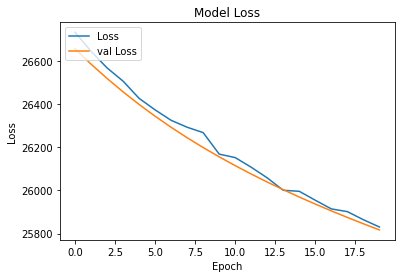

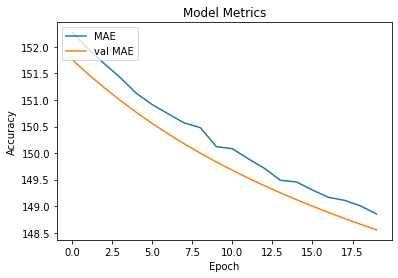

##################################################
4
##################################################
Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 25542.5645 - mean_absolute_error: 148.0355
Epoch 00001: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 43ms/step - loss: 25542.5645 - mean_absolute_error: 148.0355 - val_loss: 26694.1426 - val_mean_absolute_error: 150.9148
Epoch 2/20
3/4 [=====================>........] - ETA: 0s - loss: 24870.1250 - mean_absolute_error: 146.3959
Epoch 00002: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 35ms/step - loss: 25515.9219 - mean_absolute_error: 147.9801 - val_loss: 26666.9531 - val_mean_absolute_error: 150.8160
Epoch 3/20
3/4 [=====================>........] - ETA: 0s - loss: 25324.2578 - mean_absolute_error: 147.6831
Epoch 00003: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 38ms/step - loss: 25487.1621 - mean_ab

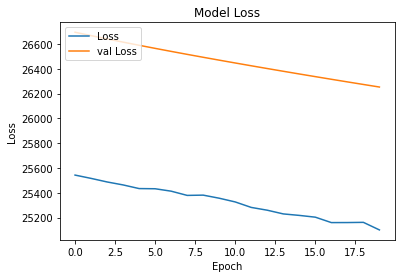

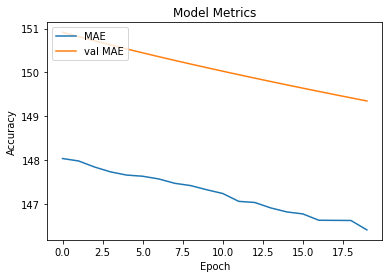

##################################################
5
##################################################
Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 24848.5391 - mean_absolute_error: 145.7237
Epoch 00001: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 47ms/step - loss: 24848.5391 - mean_absolute_error: 145.7237 - val_loss: 27148.0391 - val_mean_absolute_error: 151.7229
Epoch 2/20
3/4 [=====================>........] - ETA: 0s - loss: 25325.8594 - mean_absolute_error: 147.2200
Epoch 00002: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 35ms/step - loss: 24848.5762 - mean_absolute_error: 145.7277 - val_loss: 27127.4883 - val_mean_absolute_error: 151.6526
Epoch 3/20
3/4 [=====================>........] - ETA: 0s - loss: 24469.1797 - mean_absolute_error: 144.7119
Epoch 00003: val_loss did not improve from 25719.25977
4/4 [==============================] - 0s 36ms/step - loss: 24807.8789 - mean_ab

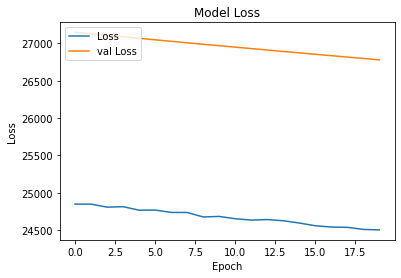

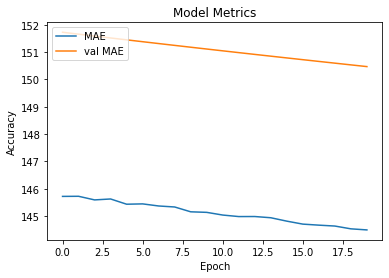

In [104]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

count = 0 
for train_index, test_index in kf.split(features, target):
    count+=1
    print('#'*50)
    print(count)
    print('#'*50)
    X_train, X_test = np.array(features[train_index], dtype=np.float), np.array(features[test_index], dtype=np.float)
    y_train, y_test = np.array(target[train_index], dtype=np.float), np.array(target[test_index], dtype=np.float)

    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE, epochs=EPOCHS,
        validation_data=(X_test, y_test),
        callbacks=[checkpointer, tensorboard], verbose=1
    )
    plot_model_train_history(history)

# model.save(os.path.join("/models", model_name) + ".h5")

In [105]:
last_sequence

array([[1.75095451, 1.73846458, 1.71627321, 1.68742862, 1.69080314,
        0.41109807],
       [1.77112334, 1.75693659, 1.73365296, 1.71055234, 1.71340153,
        0.48493181],
       [1.75681617, 1.77392633, 1.72391093, 1.69253337, 1.69579187,
        0.58236075],
       [1.76807688, 1.7537439 , 1.72574244, 1.7081143 , 1.71101881,
        0.4049447 ],
       [1.79079094, 1.781528  , 1.75746243, 1.72487619, 1.72739992,
        0.42845106],
       [1.81161542, 1.79004184, 1.77464739, 1.73657145, 1.73882944,
        0.41947226],
       [1.82225908, 1.79737754, 1.78672753, 1.74841902, 1.75040785,
        0.37452791],
       [1.8315916 , 1.81706585, 1.79576816, 1.77276193, 1.77732327,
        0.40574022],
       [1.84107828, 1.84253138, 1.80726369, 1.79135242, 1.79554059,
        0.42492491],
       [1.87860086, 1.85256564, 1.82156504, 1.77763811, 1.78210157,
        0.45256533],
       [1.8566966 , 1.83835055, 1.79155954, 1.76331427, 1.76806525,
        0.51607651],
       [1.82723386, 1

In [106]:
prediction = model.predict(np.expand_dims(np.transpose(last_sequence), axis=0))
cols_scaler['adjclose'].inverse_transform(prediction)

array([[5650.8467]], dtype=float32)